<a href="https://colab.research.google.com/github/bleamer/eva5/blob/master/w9-Data_Augmentation/w9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


!pwd

In [3]:
import os
os.chdir('/content/drive/My Drive/eva5/w9-Data Augmentation/')

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

from model.train import train
from model.cnn import Net
from model.resnet import ResNet18
from model.eval import val
from model.utils import cuda_init, cross_entropy_loss, sgd_optimizer, model_summary

from dataset.dataset import DS_Cifar10
from dataset.download import download_cifar10

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm



### Init Device

In [5]:
RAND_VAL = 42

TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = TRAIN_BATCH_SIZE
NUM_WORKER = 64

In [6]:
cuda, dev = cuda_init(RAND_VAL)
print(cuda, dev)

True cuda


In [7]:
!nvidia-smi --query-gpu=timestamp,gpu_name,utilization.gpu,utilization.memory --format=csv

timestamp, name, utilization.gpu [%], utilization.memory [%]
2020/09/26 12:43:46.673, Tesla P100-PCIE-16GB, 0 %, 0 %


### Fetch and Check the data

In [8]:
hflip = 0.2
vflip = 0.1
rotation = 12.0

In [9]:
DS = DS_Cifar10(path='/tmp', hflip = 0.2, vflip = 0.1,rotation = 12.0)
Classes = DS.classes

Transformations
{'path': '/tmp', 'hflip': 0.2, 'vflip': 0.1, 'rotation': 12.0}
path /tmp


Extracting /tmp/cifar10/cifar-10-python.tar.gz to /tmp/cifar10
Transformations
{'train': False, 'path': '/tmp', 'hflip': 0.2, 'vflip': 0.1, 'rotation': 12.0}
path /tmp
Files already downloaded and verified


### Data Loaders

In [10]:
train_loader = DS.loader(batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKER, cuda=cuda)
test_loader = DS.loader(train = False, batch_size=TEST_BATCH_SIZE, num_workers=NUM_WORKER, cuda=cuda)

{'batch_size': 64, 'num_workers': 64, 'cuda': True}
train True
{'train': False, 'batch_size': 64, 'num_workers': 64, 'cuda': True}
train False


In [11]:
DROPOUT = 0.1
# model = Net(DROPOUT).to(dev)
model = ResNet18().to(dev)

In [12]:
image_size = DS.image_size
model_summary(model, image_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [13]:
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim

EPOCHS = 2
LEARNING_RATE = 0.01
MOMENTUM = 0.9


losses = []
accuracies = []
incorrect_samples = []

criterion = cross_entropy_loss()  # Create loss function
optimizer = sgd_optimizer(model, LEARNING_RATE, MOMENTUM)  # Create optimizer

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = StepLR(optimizer, step_size=10, gamma=0.3)

for epoch in tqdm(range(1, EPOCHS + 1)):
    print(f'Epoch {epoch}:')
    train(model, train_loader, dev, optimizer, criterion)
    scheduler.step()
    val(model, test_loader, dev, criterion, losses, accuracies, incorrect_samples)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:


 50%|█████     | 1/2 [00:39<00:39, 39.53s/it]


Validation set: Average loss: 0.0188, Accuracy: 5918/10000 (59.18%)

Epoch 2:


100%|██████████| 2/2 [01:18<00:00, 39.39s/it]


Validation set: Average loss: 0.0129, Accuracy: 7256/10000 (72.56%)



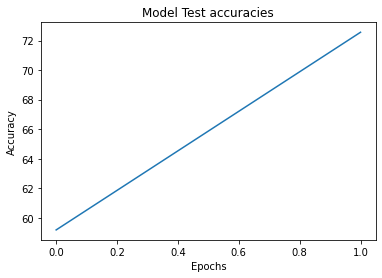

In [14]:
fig, ax = plt.subplots()
ax.plot(accuracies)
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Model Test accuracies')
plt.savefig('Accuracies.png')
plt.show()

In [15]:
total_params = sum(param.numel() for name, param in  model.named_parameters())


In [16]:
readme = f'''

# Data Augmentation | GradCAM
This notebook implements CIFAR10 classification using ResNet NN architecture using PyTorch 

Here we use Data Augmentation implementusing [Albumentations](https://github.com/albumentations-team/albumentations) library

The results with using ResNet18 architecture with (2,2,2,2), that is, 4 residual blocks of size 2 each.
 
----
| Attribute | Value |
|:--- | :--- |
| Test Accuracy | {np.max(accuracies)} |
| Trained Parameter count   |{total_params} |
| Dropout | {DROPOUT} |
| Total Epochs | {EPOCHS} |
| Batch Size | {TRAIN_BATCH_SIZE}|

----

![](Accuracies.png)

The model uses:
* 3x3 Convolution
* Batch Normalization
* Max Pooling
* 4 X Residual networks of size 2 

To run 

You can install dependencies using  
`$ pip install -r req.txt`

'''

with open('README.md', 'w') as f:
    f.write(readme)

In [17]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [18]:

# %cd drive/My\ Drive/
# !git clone https://github.com/bleamer/eva5.git
# import os
# os.chdir('eva5')
# os.getcwd()



In [20]:
# import os
# os.getcwd()
# # os.chdir('drive/My Drive/eva5')
# os.getcwd()


'/content/drive/My Drive/eva5/w9-Data Augmentation'

In [24]:
!pip install -q -r req.txt